# Manual Segmentation for Comparative Analysis

This notebook implements manual segmentation based on predictor variables (agents) with differential aggregation strategies.

**Approach:** Manually segment the cohort based on specific predictor variable criteria (age > 50 AND sex_isFemale == false), then apply different aggregation functions to different segments:
- **Filtered subgroup** (males over 50): Use MEAN aggregation to capture influence of extreme values
- **Rest of cohort**: Use MEDIAN aggregation for robust central tendency

This demonstrates how analysts can apply hypothesis-driven filtering and differential aggregation strategies for targeted comparative analysis.

In [1]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cgt_perezsechi.visualization.graph import draw
from cgt_perezsechi.manipulation.norm import normalize_psi, normalize_r

c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configure matplotlib for VS Code Jupyter
%matplotlib inline

In [3]:
# Load data
X = pd.read_pickle("../data/x_values.pkl")
num_patients = 500
X_shapley = X.iloc[:num_patients, :]
shap_values = np.load("../data/shap_values.npy")
shap_interaction_values = np.load("../data/shap_interaction_values.npy")

print(f"Loaded data: {num_patients} patients, {X_shapley.shape[1]} features")
print(f"SHAP values shape: {shap_values.shape}")
print(f"SHAP interaction values shape: {shap_interaction_values.shape}")

Loaded data: 500 patients, 80 features
SHAP values shape: (500, 80)
SHAP interaction values shape: (500, 80, 80)


## Manual Segmentation Based on Predictor Variables

We create a manual filter based on specific predictor variable criteria:
- **Subgroup of interest**: Males over 50 years old (age > 50 AND sex_isFemale == false)
- **Rest of cohort**: All other individuals

In [4]:
# Create manual segmentation mask
# Subgroup: age > 50 AND sex_isFemale == false (males over 50)
age_over_50 = X_shapley['age'] > 50
is_male = X_shapley['sex_isFemale'] == False

subgroup_mask = age_over_50 & is_male
rest_mask = ~subgroup_mask

# Display segmentation statistics
print("\n=== Manual Segmentation Statistics ===")
print(f"\nSubgroup (males over 50):")
print(f"  N = {subgroup_mask.sum()} patients ({subgroup_mask.sum()/num_patients*100:.1f}%)")
print(f"  Age range: [{X_shapley[subgroup_mask]['age'].min():.0f}, {X_shapley[subgroup_mask]['age'].max():.0f}]")
print(f"  Age mean: {X_shapley[subgroup_mask]['age'].mean():.1f}")

print(f"\nRest of cohort:")
print(f"  N = {rest_mask.sum()} patients ({rest_mask.sum()/num_patients*100:.1f}%)")
print(f"  Age range: [{X_shapley[rest_mask]['age'].min():.0f}, {X_shapley[rest_mask]['age'].max():.0f}]")
print(f"  Age mean: {X_shapley[rest_mask]['age'].mean():.1f}")
print(f"  Females: {X_shapley[rest_mask]['sex_isFemale'].sum()} ({X_shapley[rest_mask]['sex_isFemale'].sum()/rest_mask.sum()*100:.1f}%)")


=== Manual Segmentation Statistics ===

Subgroup (males over 50):
  N = 111 patients (22.2%)
  Age range: [51, 74]
  Age mean: 63.8

Rest of cohort:
  N = 389 patients (77.8%)
  Age range: [25, 74]
  Age mean: 44.9
  Females: 295 (75.8%)


## Build Networks with Differential Aggregation

We implement two different aggregation strategies:
1. **MEAN aggregation** for the subgroup (males over 50) - captures influence of extreme values
2. **MEDIAN aggregation** for the rest of cohort - provides robust central tendency

In [5]:
def build_network_with_aggregation(patient_mask, shap_values, shap_interaction_values, X_shapley, aggregation='mean'):
    """
    Build psi and r matrices for a specific patient segment with specified aggregation method
    
    Parameters:
    -----------
    patient_mask : boolean array
        Mask for selecting patients
    shap_values : numpy array
        SHAP values array
    shap_interaction_values : numpy array
        SHAP interaction values array
    X_shapley : DataFrame
        Feature dataframe
    aggregation : str, default='mean'
        Aggregation method: 'mean' or 'median'
    
    Returns:
    --------
    psi_1, r_1, psi_2, r_2 : DataFrames
        Non-normalized and normalized node/edge weights
    """
    # Filter SHAP values for this segment
    segment_shap = shap_values[patient_mask]
    segment_interaction = shap_interaction_values[patient_mask]
    
    # Calculate psi_1 (node weights) using specified aggregation
    if aggregation == 'mean':
        # Mean aggregation - captures influence of extreme values
        aggregated_shap = np.mean(segment_shap, axis=0)
    elif aggregation == 'median':
        # Median aggregation - robust to outliers
        aggregated_shap = np.median(segment_shap, axis=0)
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation}")
    
    # Normalize by sum of absolute values
    sum_shap = np.sum(np.abs(aggregated_shap))
    psi_1 = pd.DataFrame()
    psi_1['value'] = aggregated_shap / sum_shap
    psi_1.set_index(X_shapley.columns, inplace=True)
    
    # Calculate r_1 (edge weights) - remove diagonal
    n_patients_segment = segment_interaction.shape[0]
    n_variables = segment_interaction.shape[1]
    
    filtered_interaction = np.nan_to_num(segment_interaction.copy())
    idx_patients = np.repeat(np.arange(n_patients_segment), n_variables)
    idx_variables = np.tile(np.arange(n_variables), n_patients_segment)
    filtered_interaction[idx_patients, idx_variables, idx_variables] = 0
    
    # Apply same aggregation method to interactions
    if aggregation == 'mean':
        aggregated_interaction = np.mean(filtered_interaction, axis=0)
    elif aggregation == 'median':
        aggregated_interaction = np.median(filtered_interaction, axis=0)
    
    # Normalize by sum of absolute values
    sum_interaction = np.sum(np.abs(aggregated_interaction))
    
    r_1 = pd.DataFrame(aggregated_interaction / sum_interaction)
    r_1.rename(columns=dict(list(zip(r_1.columns, X_shapley.columns))), inplace=True)
    r_1.set_index(X_shapley.columns, inplace=True)
    
    # Normalize for visualization
    psi_2 = normalize_psi(psi_1)
    r_2 = normalize_r(r_1)
    
    return psi_1, r_1, psi_2, r_2

In [6]:
# Clean SHAP values (handle NaN)
shap_values_clean = np.nan_to_num(shap_values)

# Build network for subgroup with MEAN aggregation
print("Building network for subgroup (males over 50) with MEAN aggregation...")
subgroup_psi_1, subgroup_r_1, subgroup_psi_2, subgroup_r_2 = build_network_with_aggregation(
    subgroup_mask, shap_values_clean, shap_interaction_values, X_shapley, aggregation='mean'
)
print("  Done.")

# Build network for rest of cohort with MEDIAN aggregation
print("\nBuilding network for rest of cohort with MEDIAN aggregation...")
rest_psi_1, rest_r_1, rest_psi_2, rest_r_2 = build_network_with_aggregation(
    rest_mask, shap_values_clean, shap_interaction_values, X_shapley, aggregation='median'
)
print("  Done.")

Building network for subgroup (males over 50) with MEAN aggregation...
  Done.

Building network for rest of cohort with MEDIAN aggregation...
  Done.


c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_edge_width = r.applymap(lambda x: abs(x)).max().max()
c:\Workspace\IJAR\IJAR-python\.venv\Lib\site-packages\cgt_perezsechi\manipulation\norm.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r = r.copy().applymap(lambda x: x / max_edge_width)


## Visualization Setup

In [7]:
shap_cmap = shap.plots.colors.red_blue
positive_color = shap_cmap(0.0)[:3]
negative_color = shap_cmap(1.0)[:3]

positive_alpha = 0.01
negative_alpha = 0.01
positive_beta = 0
negative_beta = 0

## Network Visualization: Subgroup (Males over 50) with Mean Aggregation

This network uses MEAN aggregation to capture the influence of extreme values in the subgroup.

Network for Males over 50 (N=111)
Aggregation method: MEAN



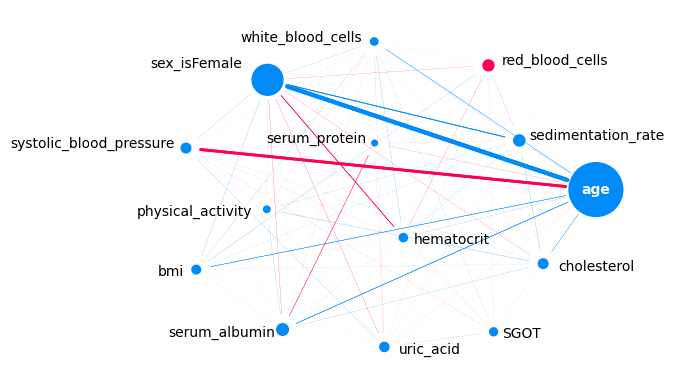

In [17]:
print(f"Network for Males over 50 (N={subgroup_mask.sum()})")
print("Aggregation method: MEAN")
print()

draw(
    psi=subgroup_psi_2,
    r=subgroup_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)

## Network Visualization: Rest of Cohort with Median Aggregation

This network uses MEDIAN aggregation for robust central tendency, less sensitive to outliers.

Network for Rest of Cohort (N=389)
Aggregation method: MEDIAN



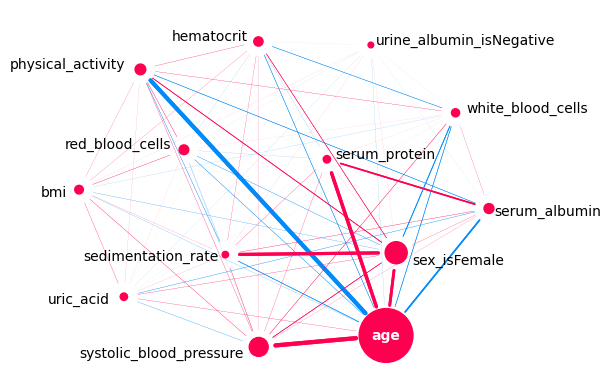

In [16]:
print(f"Network for Rest of Cohort (N={rest_mask.sum()})")
print("Aggregation method: MEDIAN")
print()

draw(
    psi=rest_psi_2,
    r=rest_r_2,
    positive_alpha=positive_alpha,
    negative_alpha=negative_alpha,
    positive_beta=positive_beta,
    negative_beta=negative_beta,
    negative_color=negative_color,
    positive_color=positive_color,
)

## Comparative Analysis: Top Features by Segment

In [10]:
# Compare top features across segments
def get_top_features(psi, n=10):
    return psi['value'].abs().nlargest(n)

print("\n" + "="*70)
print("Top 10 Features by Segment")
print("="*70)

print(f"\nSUBGROUP (Males over 50, N={subgroup_mask.sum()}):")
print("Aggregation: MEAN")
print("-" * 50)
subgroup_top = get_top_features(subgroup_psi_1)
for idx, (feature, value) in enumerate(subgroup_top.items(), 1):
    direction = "risk" if subgroup_psi_1.loc[feature, 'value'] > 0 else "protective"
    print(f"  {idx:2d}. {feature:30s}: {value:7.4f} ({direction})")

print(f"\nREST OF COHORT (N={rest_mask.sum()}):")
print("Aggregation: MEDIAN")
print("-" * 50)
rest_top = get_top_features(rest_psi_1)
for idx, (feature, value) in enumerate(rest_top.items(), 1):
    direction = "risk" if rest_psi_1.loc[feature, 'value'] > 0 else "protective"
    print(f"  {idx:2d}. {feature:30s}: {value:7.4f} ({direction})")


Top 10 Features by Segment

SUBGROUP (Males over 50, N=111):
Aggregation: MEAN
--------------------------------------------------
   1. age                           :  1.0000 (risk)
   2. sex_isFemale                  :  0.3281 (risk)
   3. serum_albumin                 :  0.0468 (risk)
   4. sedimentation_rate            :  0.0427 (risk)
   5. red_blood_cells               :  0.0409 (protective)
   6. systolic_blood_pressure       :  0.0323 (risk)
   7. cholesterol                   :  0.0317 (risk)
   8. uric_acid                     :  0.0291 (risk)
   9. bmi                           :  0.0262 (risk)
  10. hematocrit                    :  0.0230 (risk)

REST OF COHORT (N=389):
Aggregation: MEDIAN
--------------------------------------------------
   1. age                           :  1.0000 (protective)
   2. sex_isFemale                  :  0.1680 (protective)
   3. systolic_blood_pressure       :  0.1240 (protective)
   4. physical_activity             :  0.0396 (protective)
 